# GAN（生成对抗式网络）

In [274]:
import datetime as dt
import os
import warnings
from collections import UserDict
from tqdm import tqdm # 打印进度条

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px  
import plotly.graph_objects as go

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## GAN基本概念

GAN的全称是Generative adversarial network，中文翻译过来就是生成对抗网络。生成对抗网络其实是两个网络的组合：生成网络（Generator）负责生成模拟数据；判别网络Discriminator）负责判断输入的数据是真实的还是生成的。生成网络要不断优化自己生成的数据让判别网络判断不出来，判别网络也要优化自己让自己判断得更准确。二者关系形成对抗，因此叫对抗网络。

# VAE（变分自编码器）

## 数据准备

In [246]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [ ]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [247]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load", "temp"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 2)
x_valid shape: (1464, 2) y_valid shape: (1464, 2)
x_test shape: (1464, 2) y_test shape: (1464, 2)


In [248]:
# 生成tensor数据
def rnn_create_dataset(feature, target, lookback, step, batch_size):
    """
    @参数设置：
    feature：输入向量
    target：输出向量
    """
    X, y = [], []
    #循环生成数据
    for i in range(lookback, len(feature), step):
        feat = feature[i - lookback:i]
        tar = target[i - lookback:i]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader，drop_last这个是对最后的未完成的batch来说的，后面剩余的不够batch_size的会丢弃
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size, drop_last=False)
    return X, y, loader

In [249]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "step": 1,
    "batch_size": 64,
}
X_train, y_train, train_loader = rnn_create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = rnn_create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = rnn_create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23370, 6, 2]),y_size: torch.Size([23370, 6, 2]),loader_len: 366
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23
X_size: torch.Size([1458, 6, 2]),y_size: torch.Size([1458, 6, 2]),loader_len: 23


## 结果分析

In [8]:
#损失函数图
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, linestyle='-',color = '#11b3b6')
    plt.plot(train_losses, linestyle='-',color = '#f14643')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Progress")
    plt.legend(["Validation", "Training"])
    plt.show()

## 模型训练

In [250]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 定义变分自编码器模型
    class VAE(nn.Module):
        def __init__(self, input_dim, hidden_dim, latent_dim):
            super(VAE, self).__init__()

            # Encoder
            self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)  # LSTM用于编码输入序列
            self.fc_mean = nn.Linear(hidden_dim*2, latent_dim) # 输出均值
            self.fc_logvar = nn.Linear(hidden_dim*2, latent_dim) # 输出对数方差

            # Decoder
            self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = True)  # LSTM用于解码潜在表示
            self.fc_output = nn.Linear(hidden_dim*2, input_dim) # 输出重建的序列

        def encode(self, x):
            x, (encoder_hidden, encoder_cell) = self.encoder_lstm(x)  # LSTM编码器的输出
            mean = self.fc_mean(x) # 计算均值
            logvar = self.fc_logvar(x) # 计算对数方差
            return mean, logvar, encoder_hidden, encoder_cell

        def reparameterize(self, mean, logvar):
            std = torch.exp(0.5 * logvar) # 计算标准差
            eps = torch.randn_like(std) # 从标准正态分布中采样噪声，并生成一个与输入张量形状相同的张量，目的是对抗
            return mean + eps * std # 重新参数化，随着损失函数变小，使其服从标准正态分布

        def decode(self, z):
            decoder_hidden, decoder_cell = self.encoder_hidden, self.encoder_cell
            x, _ = self.decoder_lstm(z, (decoder_hidden, decoder_cell))  # z服从标准正态分布
            x = self.fc_output(x) # 输出重建的序列
            return x

        def forward(self, x):
            mean, logvar, self.encoder_hidden, self.encoder_cell = self.encode(x) # 编码输入序列
            z = self.reparameterize(mean, logvar) # 重参数化，形状为(batch_size, seq_length, latent_dim)
            x_recon = self.decode(z) # 解码潜在表示
            return x_recon, mean, logvar

    # 定义变分自编码器的损失函数
    def vae_loss(x_recon, x, mean, logvar):
        # 重建损失（MSE损失）
        recon_loss = nn.functional.mse_loss(x_recon, x)

        # KL散度损失，KL散度通常用于衡量潜在空间中的编码分布与先验分布（通常是标准正态分布）之间的差异。
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) # 散度越小意味着两个分布越接近

        return recon_loss + kl_loss
        
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建模型和优化器
    input_dim = 2  # 输入数据的维度
    hidden_dim = 64  # LSTM层的隐藏单元数
    latent_dim = 16  # 潜在空间的维度
    model = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            x_recon, mean, logvar = model(inputs_batch)
            train_loss = vae_loss(x_recon, inputs_batch, mean, logvar)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                x_recon, mean, logvar = model(inputs_batch)
                val_loss = vae_loss(x_recon, inputs_batch, mean, logvar)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    if plots:
        plot_loss(train_losses, val_losses)
    return model

  3%|██▊                                                                                | 1/30 [00:05<02:35,  5.36s/it]

Epoch [1/30], Training Loss: 0.2436, Validation Loss: 0.0156


  7%|█████▌                                                                             | 2/30 [00:11<02:37,  5.63s/it]

Epoch [2/30], Training Loss: 0.0034, Validation Loss: 0.0036


 10%|████████▎                                                                          | 3/30 [00:17<02:35,  5.77s/it]

Epoch [3/30], Training Loss: 0.0015, Validation Loss: 0.0028


 13%|███████████                                                                        | 4/30 [00:23<02:32,  5.87s/it]

Epoch [4/30], Training Loss: 0.0012, Validation Loss: 0.0025


 17%|█████████████▊                                                                     | 5/30 [00:29<02:26,  5.88s/it]

Epoch [5/30], Training Loss: 0.0010, Validation Loss: 0.0021


 20%|████████████████▌                                                                  | 6/30 [00:34<02:21,  5.90s/it]

Epoch [6/30], Training Loss: 0.0008, Validation Loss: 0.0021


 23%|███████████████████▎                                                               | 7/30 [00:40<02:14,  5.87s/it]

Epoch [7/30], Training Loss: 0.0007, Validation Loss: 0.0018


 27%|██████████████████████▏                                                            | 8/30 [00:46<02:09,  5.89s/it]

Epoch [8/30], Training Loss: 0.0007, Validation Loss: 0.0016


 30%|████████████████████████▉                                                          | 9/30 [00:53<02:06,  6.04s/it]

Epoch [9/30], Training Loss: 0.0006, Validation Loss: 0.0022


 33%|███████████████████████████▎                                                      | 10/30 [00:59<02:00,  6.05s/it]

Epoch [10/30], Training Loss: 0.0006, Validation Loss: 0.0013


 37%|██████████████████████████████                                                    | 11/30 [01:05<01:54,  6.04s/it]

Epoch [11/30], Training Loss: 0.0006, Validation Loss: 0.0017


 40%|████████████████████████████████▊                                                 | 12/30 [01:11<01:48,  6.00s/it]

Epoch [12/30], Training Loss: 0.0006, Validation Loss: 0.0013


 43%|███████████████████████████████████▌                                              | 13/30 [01:18<01:46,  6.29s/it]

Epoch [13/30], Training Loss: 0.0005, Validation Loss: 0.0012


 47%|██████████████████████████████████████▎                                           | 14/30 [01:24<01:41,  6.37s/it]

Epoch [14/30], Training Loss: 0.0005, Validation Loss: 0.0012


 50%|█████████████████████████████████████████                                         | 15/30 [01:30<01:34,  6.28s/it]

Epoch [15/30], Training Loss: 0.0005, Validation Loss: 0.0011


 53%|███████████████████████████████████████████▋                                      | 16/30 [01:36<01:26,  6.17s/it]

Epoch [16/30], Training Loss: 0.0005, Validation Loss: 0.0031


 57%|██████████████████████████████████████████████▍                                   | 17/30 [01:42<01:19,  6.10s/it]

Epoch [17/30], Training Loss: 0.0006, Validation Loss: 0.0014


 60%|█████████████████████████████████████████████████▏                                | 18/30 [01:48<01:12,  6.02s/it]

Epoch [18/30], Training Loss: 0.0005, Validation Loss: 0.0011


 63%|███████████████████████████████████████████████████▉                              | 19/30 [01:54<01:06,  6.00s/it]

Epoch [19/30], Training Loss: 0.0004, Validation Loss: 0.0009


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [02:00<00:59,  5.98s/it]

Epoch [20/30], Training Loss: 0.0004, Validation Loss: 0.0010


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:06<00:53,  5.97s/it]

Epoch [21/30], Training Loss: 0.0004, Validation Loss: 0.0021


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [02:12<00:47,  5.96s/it]

Epoch [22/30], Training Loss: 0.0004, Validation Loss: 0.0007


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [02:18<00:41,  5.98s/it]

Epoch [23/30], Training Loss: 0.0003, Validation Loss: 0.0017


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [02:24<00:35,  5.99s/it]

Epoch [24/30], Training Loss: 0.0003, Validation Loss: 0.0010


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [02:30<00:30,  6.10s/it]

Epoch [25/30], Training Loss: 0.0003, Validation Loss: 0.0025


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [02:36<00:24,  6.04s/it]

Epoch [26/30], Training Loss: 0.0003, Validation Loss: 0.0004


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [02:42<00:18,  6.01s/it]

Epoch [27/30], Training Loss: 0.0002, Validation Loss: 0.0011


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [02:48<00:11,  6.00s/it]

Epoch [28/30], Training Loss: 0.0003, Validation Loss: 0.0005


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [02:54<00:06,  6.08s/it]

Epoch [29/30], Training Loss: 0.0002, Validation Loss: 0.0005


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:00<00:00,  6.03s/it]

Epoch [30/30], Training Loss: 0.0003, Validation Loss: 0.0013


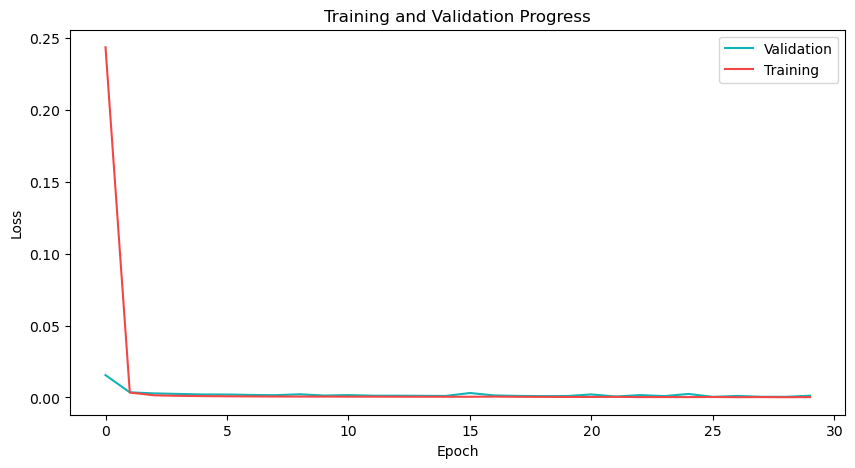

In [251]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 30,
    "verbose": True,
    "verbose": True,
}
model = train(**params3)

## 数据生成

In [267]:
def generator(data, seq_length, latent_dim, num_samples, scaler, model):
    # 设定参数
    batch_size = 1 # 默认每次只生成一组
    seq_length = seq_length
    latent_dim = latent_dim

    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    nums = data.shape[0]
    data = scaler.fit_transform(data.values.astype('float32'))

    # 生成新样本
    samples = []
    for i in range(num_samples):
        # 使用模型先跑一组数据，每次跑数据隐藏层维度都会变，会和之后跑的数据分布相同
        k = np.random.randint(0, nums-seq_length) # 随机生成一个整数
        input_data = torch.tensor(data[k:k+seq_length, :]).unsqueeze(0) # 随机抽样
        input_data = input_data.to(device) # 将数据应用到GPU
        y_pred, mean, logvar = model(input_data) # 使隐藏层输入batch_size变为1
    
        # 在潜在空间中生成一个随机样本
        new_input_data = torch.randn((batch_size, seq_length, latent_dim))  
        new_input_data = new_input_data.to(device) 
        generated_samples = model.decode(new_input_data)
        generated_samples = generated_samples[:, -1, :] # 取最后一组数据
        generated_samples = generated_samples.cpu().detach().numpy()
        generated_samples = scaler.inverse_transform(generated_samples) # 反归一化
        samples.append(generated_samples)

    # 重塑维度
    samples = np.squeeze(np.array(samples))
    
    return samples

In [281]:
# 生成时序数据
params6 = {
    "data": ts_data,
    "seq_length": 6,
    "latent_dim": 16,
    "num_samples": 3000,
    "scaler": scaler,
    "model": model,
}
new_data = generator(**params6)

## 分布差异

<Axes: ylabel='Density'>

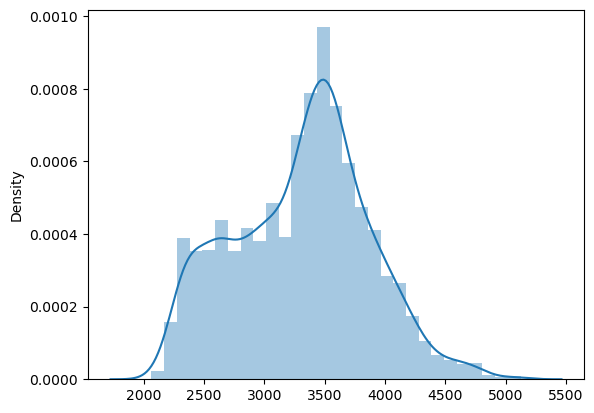

In [282]:
sns.distplot(new_data[:,0]) # 生成的数据分布

<Axes: ylabel='Density'>

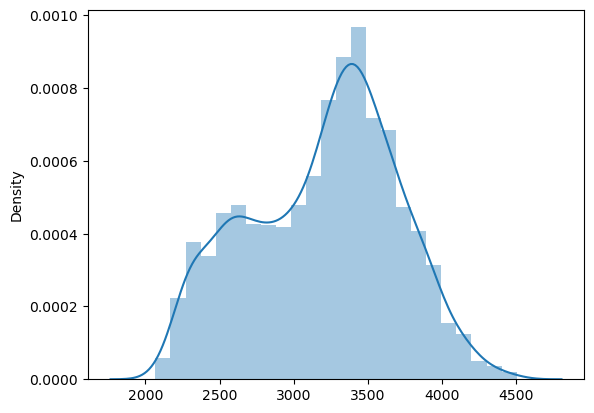

In [291]:
sns.distplot(ts_data['load'].values[:3000]) # 原始的数据分布

In [289]:
import scipy.stats

In [303]:
p = new_data[:,0]
q = ts_data['load'].values[:3000]
scipy.stats.entropy(p, q)

0.03739433877942046

In [306]:
p = np.sort(p)
q = np.sort(q)

In [308]:
# 编程实现
KL = 0.0
for i in range(3000):
    KL += p[i] * np.log(p[i] / q[i])

In [309]:
KL

321912.6951684307

In [108]:
X_test[-1:,:,:].squeeze()

tensor([[0.9096, 0.2454],
        [0.8559, 0.2025],
        [0.7722, 0.1657],
        [0.7023, 0.1412],
        [0.6195, 0.1472],
        [0.5425, 0.1165]])

In [131]:
X_test.shape

torch.Size([1458, 6, 2])

In [233]:
scaler.inverse_transform(X_train[-1:,:,:].squeeze()) # 反归一化

array([[3634.28,   54.67],
       [3648.74,   54.17],
       [3657.  ,   53.17],
       [3588.16,   52.83],
       [3432.57,   52.33],
       [3241.18,   51.83]])

In [183]:
nums = ts_data.shape[0]

In [186]:
np.random.randint(0, nums)

21446

In [191]:
torch.tensor(ts_data.values[0:6, :]).unsqueeze(0).shape

torch.Size([1, 6, 2])

In [52]:
ts_data['load'].min()

1979.0

In [56]:
ts_data['temp'].max()

95.0

In [57]:
ts_data['temp'].min()

-13.67

In [324]:
bins1

array([2063.14, 2124.36, 2185.58, 2246.81, 2308.03, 2369.25, 2430.47,
       2491.69, 2552.92, 2614.14, 2675.36, 2736.58, 2797.81, 2859.03,
       2920.25, 2981.47, 3042.69, 3103.92, 3165.14, 3226.36, 3287.58,
       3348.8 , 3410.03, 3471.25, 3532.47, 3593.69, 3654.92, 3716.14,
       3777.36, 3838.58, 3899.8 , 3961.03, 4022.25, 4083.47, 4144.69,
       4205.92, 4267.14, 4328.36, 4389.58, 4450.8 , 4512.03, 4573.25,
       4634.47, 4695.69, 4756.91, 4818.14, 4879.36, 4940.58, 5001.8 ,
       5063.02, 5124.25], dtype=float32)

In [326]:
np.sum(hist1)

0.016333956307811235

In [325]:
hist1

array([1.09e-05, 5.99e-05, 1.20e-04, 2.67e-04, 4.63e-04, 4.08e-04,
       2.99e-04, 3.32e-04, 4.36e-04, 4.46e-04, 3.54e-04, 3.54e-04,
       3.70e-04, 4.63e-04, 3.43e-04, 4.85e-04, 4.74e-04, 4.25e-04,
       3.81e-04, 6.81e-04, 7.08e-04, 7.62e-04, 8.82e-04, 1.02e-03,
       8.17e-04, 7.35e-04, 6.59e-04, 4.36e-04, 5.12e-04, 3.81e-04,
       4.03e-04, 3.32e-04, 2.67e-04, 2.89e-04, 2.01e-04, 1.31e-04,
       1.52e-04, 8.17e-05, 6.53e-05, 5.99e-05, 4.36e-05, 4.36e-05,
       5.99e-05, 4.90e-05, 2.72e-05, 2.18e-05, 0.00e+00, 1.09e-05,
       0.00e+00, 1.63e-05])

KL Divergence: 0.027949849251781497


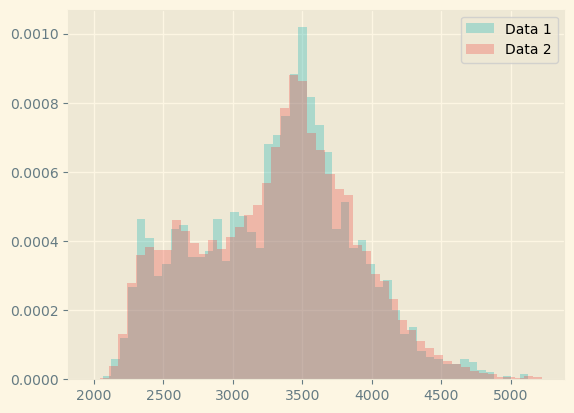

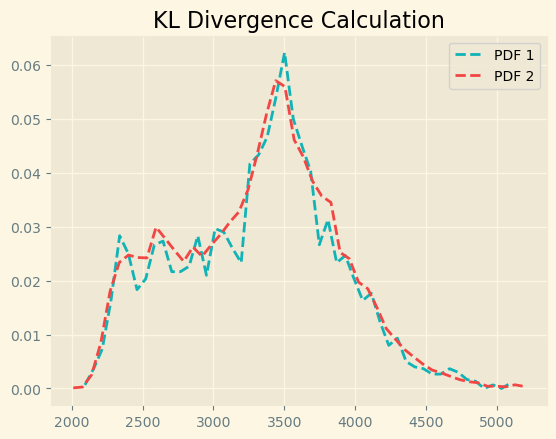

In [336]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# 生成两个示例数据集
np.random.seed(42)
data1 = new_data[:,0]
data2 = ts_data['load'].values

# 生成两个直方图
hist1, bins1 = np.histogram(data1, bins=50, density=True) # hist等于频率/组距
hist2, bins2 = np.histogram(data2, bins=50, density=True)

# 计算每个区间的概率密度
pdf1 = hist1 / np.sum(hist1)
pdf2 = hist2 / np.sum(hist2)

# 计算KL散度
kl_divergence = entropy(pdf1, pdf2)

# 打印结果
print("KL Divergence:", kl_divergence)

# 绘制直方图和概率密度函数
plt.figure()
plt.hist(data1, bins=bins1, density=True, alpha=0.3, color='#11b3b6', label='Data 1', histtype='stepfilled' )
plt.hist(data2, bins=bins2, density=True, alpha=0.3, color='#f14643', label='Data 2', histtype='stepfilled')
plt.legend() 

plt.figure()
plt.plot((bins1[:-1] + bins1[1:]) / 2, pdf1, color='#11b3b6', linestyle='dashed', linewidth=2, label='PDF 1')
plt.plot((bins2[:-1] + bins2[1:]) / 2, pdf2, color='#f14643', linestyle='dashed', linewidth=2, label='PDF 2')
plt.legend() 

# 显示图例和标题
plt.legend()
plt.title('KL Divergence Calculation')
plt.show()